### Phys 629, Fall 2023, University of Mississippi


# Lecture 13, Chapter 4: Classical Statistical Inference

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 4.

***Exercises required for class participation are in <font color='red'>red</font>.***

In classification decisions, we make two types of errors. These are quite literally described as **Type I** and **Type II** errors by *Neyman & Pearson*.

**TYPE I ERRORS**
- The null hypothesis is true, but incorrectly rejected.
- These are ***false positives*** (or false alarms).
- False positive probability is dictated by the significance level $\alpha$. 

**TYPE II ERRORS**
- The null hypothesis is false, but not rejected.
- These are ***false negatives*** (or false dismissals).
- False negatives probability is dictated by a variable called $\beta$, related to $(1-\beta)$, called the ***detection probability***.

Let's take a look at Fig 4.5 of Ivezic, v2. We have two Gaussian distributions; one describing the background noise and one describing the source. These distributions overlap, as they often do in real life.

<font color='red'>Execute the following cell. We'll discuss it more below.</font>

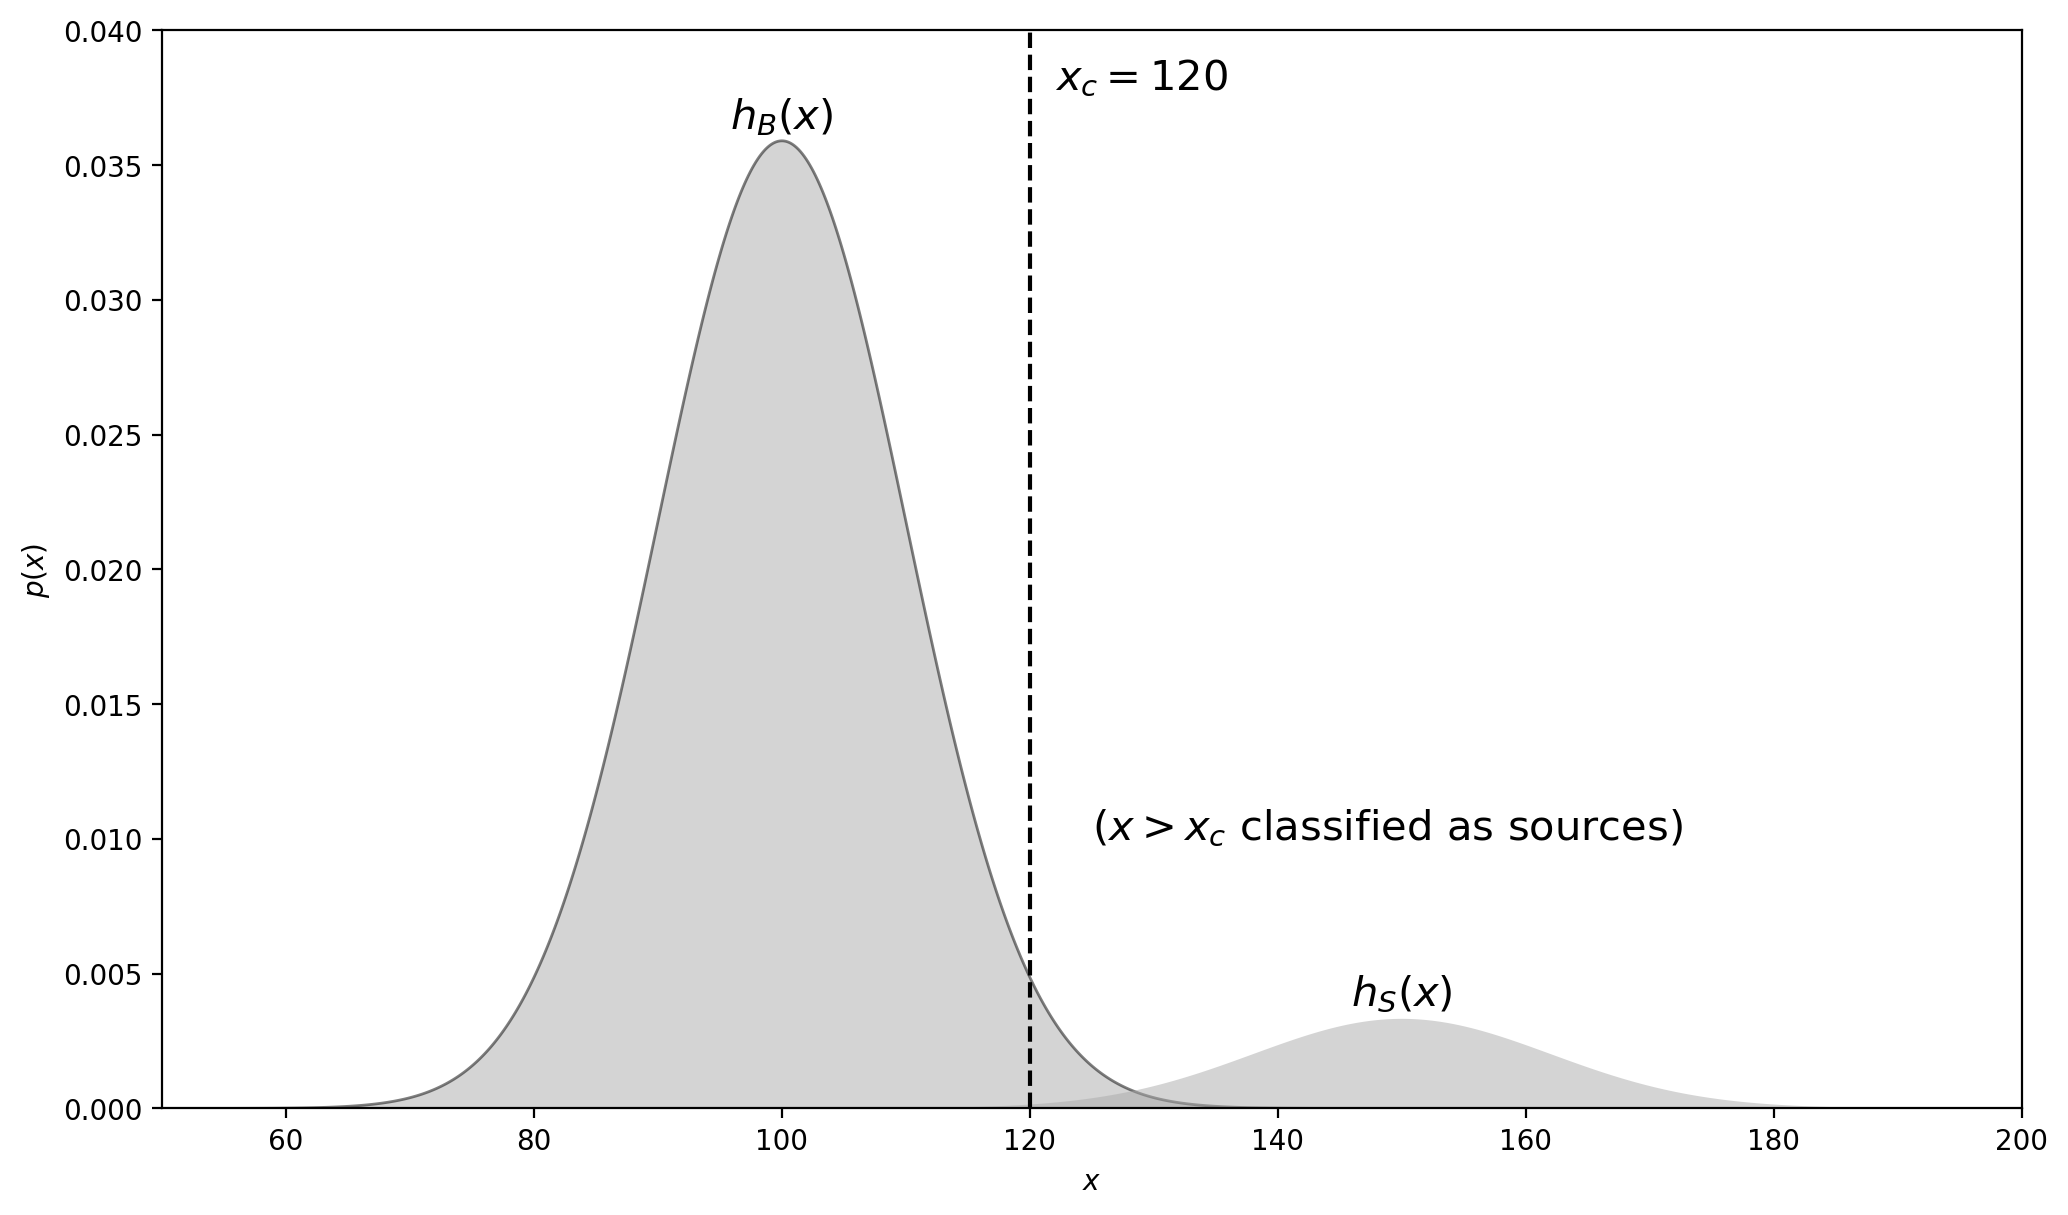

In [2]:
# %load ./scripts/fig_classification_example.py
"""
Example of classification
-------------------------
Figure 4.5.

An example of a simple classification problem between two Gaussian
distributions. Given a value of x, we need to assign that measurement to one
of the two distributions (background vs. source). The cut at xc = 120 leads
to very few Type II errors (i.e., false negatives: points from the distribution
hS with x < xc being classified as background), but this comes at the cost of
a significant number of Type I errors (i.e., false positives: points from the
distribution :math:`h_B` with x > xc being classified as sources).
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#------------------------------------------------------------
# Generate and draw the curves
import numpy as np
import scipy.stats as stats
from scipy.stats import norm

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

x = np.linspace(50, 200, 1000)
p1 = 0.9 * norm(100, 10).pdf(x)
p2 = 0.1 * norm(150, 12).pdf(x)

fig, ax = plt.subplots(figsize=(12, 7))
ax.fill(x, p1, ec='k', 
        fc='#AAAAAA', alpha=0.5)
ax.fill(x, p2, '-k', 
        fc='#AAAAAA', alpha=0.5)

ax.plot([120, 120], 
        [0.0, 0.04], '--k')

ax.text(100, 0.036, r'$h_B(x)$', ha='center', 
        va='bottom', fontsize=15)
ax.text(150, 0.0035, r'$h_S(x)$', ha='center', 
        va='bottom', fontsize=15)
ax.text(122, 0.039, r'$x_c=120$', ha='left', 
        va='top', fontsize=15)
ax.text(125, 0.01, 
        r'$(x > x_c\ {\rm classified\ as\ sources})$', 
        fontsize=15)

ax.set_xlim(50, 200)
ax.set_ylim(0, 0.04)

ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
plt.show()

In this example, we have data $\{x_i\}$ drawn from an underlying distribution

$$ h(x) = (1-a)h_B(x) + ah_S(x)$$

where $h_B(x)=\mathcal{N}(\mu=100,\sigma=10)$ is the background distribution (normalized to unity), $h_S(x)=\mathcal{N}(\mu=150,\sigma=12)$ is the source distribution (normalized to unity), and $a$ is the relative normalization factor that accounts for background noise being $(1-a)/a$ more probable than sources.

- ***If we set a classificiation threshold at $x_c=120$, calculate the Type I error (false positive) probability, $\alpha$.***
- ***For the same $x_c$, calculate the Type II error (false negative) probability, $\beta$.***

For a sample of size $N$ (containing background noise and sources), the **expected number of spurious sources (Type I / false positives)** is 

$$ n_\mathrm{spurious} = N(1-a)\alpha = N(1-a)\int_{x_c}^\infty h_B(x)dx$$ 

and the **expected number of missed sources (Type II / false negatives)** is

$$ n_\mathrm{missed} = Na\beta = Na\int_0^{x_c}h_S(x)dx.$$

The **total number of classified sources** (that is number of instances where we reject the null hypothesis) is

$$ n_\mathrm{source} = Na - n_\mathrm{missed} + n_\mathrm{spurious} = N[(1-\beta)a + (1-a)\alpha].$$

The **sample completeness** (or **detection probability**) is defined as

$$ \eta = \frac{Na - n_\mathrm{missed}}{Na} = 1-\int_0^{x_c}h_S(x)dx = 1-\beta$$

Finally, the **sample contamination** is

$$ \epsilon = \frac{n_\mathrm{spurious}}{n_\mathrm{source}}$$

where $(1-\epsilon)$ is sometimes called the **classification efficiency**.

## Comparing Distributions <a class="anchor" id="two"></a>

Hypothesis testing is strongly linked to the **comparison of distributions**. Common questions are whether two samples are drawn from the same distribution, or whether a sample is drawn from some known distribution (like a Gaussian).

Sometimes we may be only interested in the location parameter of some underlying distribution. For example, do two gravitational-wave detectors with different measurement uncertainties and local effects measure consistent masses of a merging system of black holes?

There is enormous variety in the nonparameteric and parameteric statistics to compare distributions, and we'll only look at a few. See the textbook and wider literature for further examples.

### Kolmogorov-Smirnov (KS) Test

By far the most popular nonparametric statistic to compare distribution is the KS test. We compute the empirical cdf $F(x)$ for two samples $\{x1_i\} = (1,\ldots,N_1)$ and $\{x2_i\} = (1,\ldots,N_2)$. *Recall that the empirical cdf can be calculated by sorting the samples and dividing by the sample size.*

The KS test is based on a statistic that measures the maximum difference in the cdfs of our two samples

$$ D = \mathrm{max}|F_1(x1) - F_2(x2)|$$

where $0\leq D\leq 1$. 

> The core idea is to know how often the value of $D$ computed from our data would arise by chance if both samples were drawn from the same distribution (which is our *null hypothesis* here). 

Amazingly, ***this does not depend on the underlying distribution we care about!*** Kolmogorov published the following result in 1933 and Smirnov published numerical tables in 1948. The probability of obtaining a value of $D$ larger than that observed in our data is

$$ Q_\mathrm{KS}(\lambda) = 2\sum_{k=1}^\infty (-1)^{k-1}\exp(-2k^2\lambda^2)$$

where 

$$\lambda = \left(0.12 + \sqrt{n_e} + \frac{0.11}{\sqrt{n_e}} \right)D $$

and the ***effective number of data points***, $n_e$, is

$$ n_e = \left( \frac{1}{N_1} + \frac{1}{N_2}\right)^{-1} = \frac{N_1 N_2}{N_1 + N_2}$$

If the probability that $D$ were drawn by chance is very small (low $p$-value) then we can reject the null hypothesis that the two samples were drawn from the same distribution.

For large $n_e$ we have $\lambda\approx\sqrt{n_e}D$. In fact, for $n_e>10$ we can bypass $Q_\mathrm{KS}$ entirely and compute the value of D that would correspond to a given significance level $\alpha$,

$$ D_\mathrm{KS} = \frac{C(\alpha)}{\sqrt{n_e}}$$

where $C(\alpha) = \sqrt{-\frac{1}{2}\ln(\alpha/2)}$. Some instructive significance levels are shown below (from [here](https://www.wikiwand.com/en/Kolmogorov%E2%80%93Smirnov_test)).

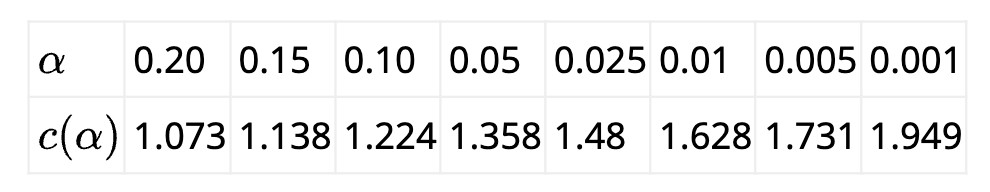

The KS test and variants can be accessed in the `scipy.stats` modules `kstest`, `ks_2samp`, and `ksone.` Let's look at a simple example for comparing a Gaussian sample to a Gaussian null hypothesis distribution.

<font color='red'>Execute the following cell</font>

In [3]:
# the kstest function is appropriate for this
np.random.seed(0)
x = np.random.normal(loc=0, scale=1, size=1000)
print(stats.kstest(x, 'norm'))

KstestResult(statistic=0.03737519429804048, pvalue=0.11930823166569182, statistic_location=0.47224715008784873, statistic_sign=1)


Null hypothesis is that both the distributions are the same. Since, $p > \alpha$ we cannot reject the null hypothesis.

Let's now compare a $t$-distribution with $100$ degrees of freedom to a Gaussian distribution. <font color='red'>Complete the following cell. Discuss with your colleagues whether the result makes sense.</font>

In [13]:
np.random.seed(987654321)
print(stats.kstest(stats.t.rvs(100, size=100), 'norm'))

KstestResult(statistic=0.07201892916547126, pvalue=0.6505883498379312, statistic_location=1.4909975365781791, statistic_sign=-1)


<font color='red'>Try again and discuss for a $t$-process with only $3$ degrees of freedom.</font>

In [9]:
np.random.seed(987654321)
print(stats.kstest(stats.t.rvs(3, size=1000), 'norm'))

KstestResult(statistic=0.059859465556672875, pvalue=0.0014777529350418995, statistic_location=1.6532447179445433, statistic_sign=-1)
